![BTS](https://github.com/vfp1/bts-dsf-2020/blob/main/Logo-BTS.jpg?raw=1)

# FINAL PROJECT

### Victor F. Pajuelo Madrigal <victor.pajuelo@bts.tech> - Data Science Foundations (2020-10-29)

Open this notebook in Google Colaboratory: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vfp1/bts-dsf-2020/blob/main/Final_project/DSF_FINAL_PROJECT.ipynb)

# Regarding the final project for the class

The final project for the class will need to draw from everything you have covered in class, at least everything relevant for your final project. For that you will need to choose a topic. You will be using **the image and text** datasets that we have seen on our sessions. 

It doesn't need to be a super revolutionary idea, but at least have in mind the issue of reducing the time between information and action. And you will need to send it to me. 

The project will need to contain the following steps:

1. Ingesting, exploring and cleaning data for your project
2. Choosing/testing of algorithm approach
3. Visualizing the results
4. Packaging the project into a product

You will be using code from class to support you on the second, third and forth parts of the project. 

I am not looking for excellence, and I do not mind that you copy/paste code, but always try to understand why. 

#Section 1

This project was divided into 2 attempts.

In section 2, a model was implemented to recognize brand logos, but with little accuracy(42%). From my point of view, larger images are required to increase accuracy.

Section 1.The model developed below showed better precision values. 

# 1.- Ingesting, exploring and cleaning data for your project

This dataset had around 3000 photos of flowers. It's contains 5 sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [ ]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

We have 3670 images

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

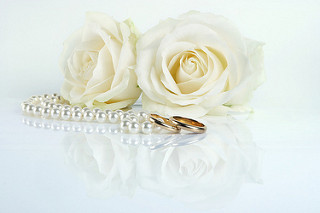

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

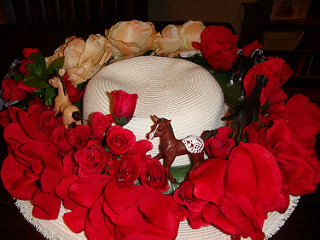

In [ ]:
PIL.Image.open(str(roses[1]))

And some sunflowers

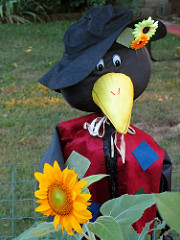

In [ ]:
sunflowers = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(sunflowers[0]))

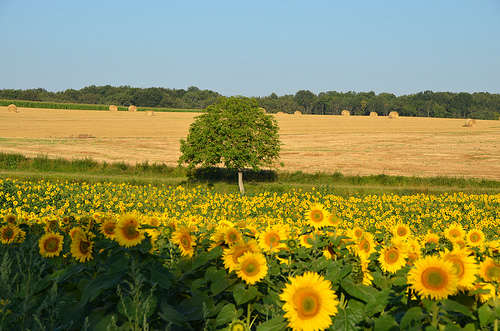

In [ ]:
PIL.Image.open(str(sunflowers[1]))

Define parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Let's load these images using the helpful image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code.

Let's use 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, #Optional float between 0 and 1, fraction of data to reserve for validation.
  subset="training", #One of "training" or "validation". Only used if validation_split is set
  seed=123, #Optional random seed for shuffling and transformations.
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Finding the class_names attribute on these datasets.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


**Visualize the data(Training)**

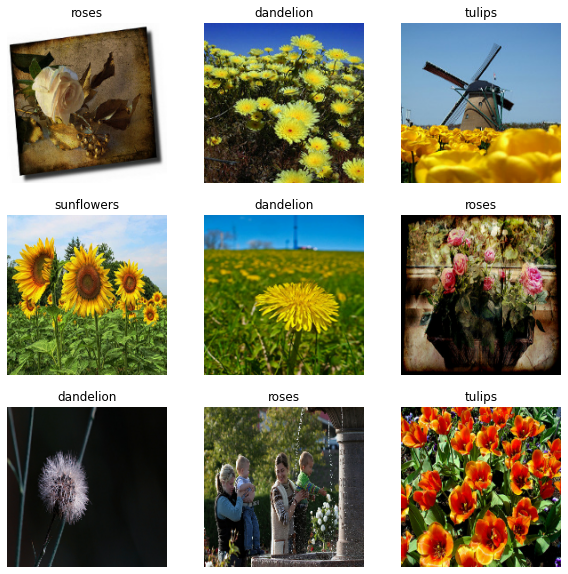

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


**Configure dataset for performance**

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking.

**Dataset.cache()** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

**Dataset.prefetch()** overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardize the data**

The RGB channel values are in the [0, 255] range. We will standardize values to be in the [0, 1] range by using a Rescaling layer.

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.02886732 1.0


# 2.- Choosing/testing of algorithm approach

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function.

**Creating the model**

In [ ]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compiling the model**

We choose Adam optimizer and parseCategoricalCrossentropy loss function.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

View all the layers of the network

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

**Training the model**

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 90s 972ms/step - loss: 1.6595 - accuracy: 0.3240 - val_loss: 1.1870 - val_accuracy: 0.5245
Epoch 2/10
92/92 [==============================] - 86s 939ms/step - loss: 1.0781 - accuracy: 0.5601 - val_loss: 1.0853 - val_accuracy: 0.5763
Epoch 3/10
92/92 [==============================] - 87s 943ms/step - loss: 0.8774 - accuracy: 0.6560 - val_loss: 0.9418 - val_accuracy: 0.6362
Epoch 4/10
92/92 [==============================] - 86s 935ms/step - loss: 0.6493 - accuracy: 0.7646 - val_loss: 0.9049 - val_accuracy: 0.6649
Epoch 5/10
92/92 [==============================] - 86s 938ms/step - loss: 0.4319 - accuracy: 0.8537 - val_loss: 1.1127 - val_accuracy: 0.6281
Epoch 6/10
92/92 [==============================] - 86s 938ms/step - loss: 0.2487 - accuracy: 0.9217 - val_loss: 1.2174 - val_accuracy: 0.6158
Epoch 7/10
92/92 [==============================] - 86s 935ms/step - loss: 0.1592 - accuracy: 0.9484 - val_loss: 1.3467 - val_accuracy: 0.6417

# 3.-Visualizing the results

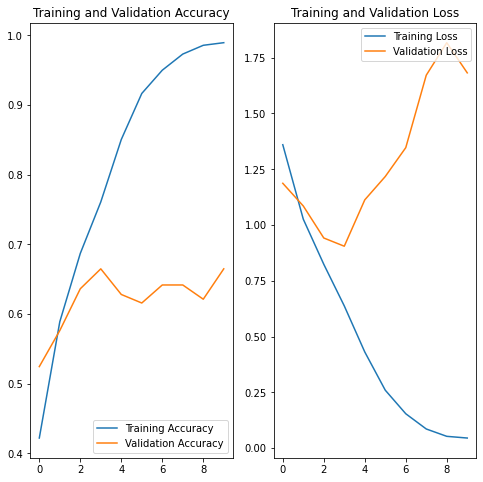

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The training accuracy is increasing linearly over time, whereas validation accuracy stalls around 65% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—**a sign of overfitting**.

It means that the model will have a difficult time generalizing on a new dataset.

**Data augmentation**

We can use Data augmentation to take the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize some examples

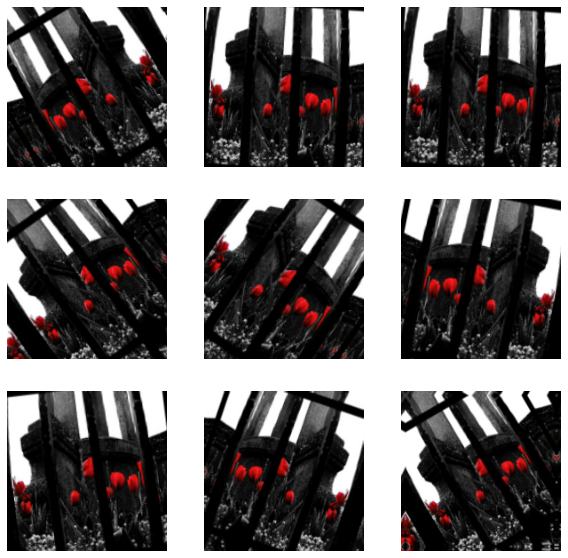

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Dropout**

We also use Dropout to reduce overfitting. It randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 101s 1s/step - loss: 1.6411 - accuracy: 0.3088 - val_loss: 1.2031 - val_accuracy: 0.5027
Epoch 2/15
92/92 [==============================] - 102s 1s/step - loss: 1.1460 - accuracy: 0.5225 - val_loss: 1.0801 - val_accuracy: 0.5627
Epoch 3/15
92/92 [==============================] - 100s 1s/step - loss: 0.9958 - accuracy: 0.5966 - val_loss: 0.9666 - val_accuracy: 0.6294
Epoch 4/15
92/92 [==============================] - 100s 1s/step - loss: 0.8868 - accuracy: 0.6471 - val_loss: 0.9929 - val_accuracy: 0.6335
Epoch 5/15
92/92 [==============================] - 100s 1s/step - loss: 0.8836 - accuracy: 0.6564 - val_loss: 0.9502 - val_accuracy: 0.6635
Epoch 6/15
92/92 [==============================] - 100s 1s/step - loss: 0.8033 - accuracy: 0.6953 - val_loss: 0.8458 - val_accuracy: 0.6553
Epoch 7/15
92/92 [==============================] - 99s 1s/step - loss: 0.7494 - accuracy: 0.7189 - val_loss: 0.8103 - val_accuracy: 0.6689
Epoch 8/15
92/

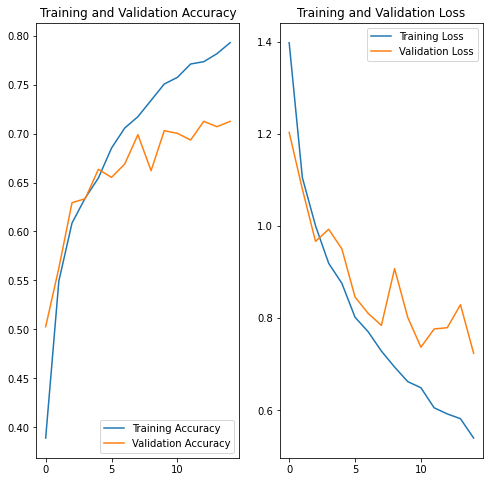

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to sunflowers with a 96.30 percent confidence.


# 4.-Packaging the project into a product

In [ ]:
tf.keras.models.save_model(model,'flower_identification.hdf5')

In [ ]:
!pip install streamlit

In [ ]:
!pip install -q streamlit
!pip install pyngrok

In [29]:
%%writefile app.py
import streamlit as st
import tensorflow as tf

st.set_option('deprecation.showfileUploaderEncoding',False)
@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/flower_identification.hdf5')
  return model
model=load_model()
st.write("""
         # Flower Classification
         """
         )

file=st.file_uploader("Please upload an flower image('daisy','dandelion','roses','sunflowers','tulips'):", type=["jpg","png","jpeg"])
import cv2
from PIL import Image, ImageOps
import numpy as np
def import_and_predict(image_data, model):

  size = (180,180)
  image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
  img = np.asarray(image)
  img_reshape = img[np.newaxis,...]
  prediction = model.predict(img_reshape)

  return prediction
if file is None:
  st.text("Please upload an image file")
else:
  image = Image.open(file)
  st.image(image, use_column_width=True)
  predictions = import_and_predict(image, model)
  class_names = ['daisy','dandelion','roses','sunflowers','tulips']
  string = "This image most likely is: "+class_names[np.argmax(predictions)]
  st.success(string)



Overwriting app.py


In [15]:
!ls

app.py	flower_identification.hdf5  sample_data


In [16]:
!ngrok authtoken XXXXXXXXXXXXXX

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
!streamlit hello


  Welcome to Streamlit. Check out our demo in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.229.86.167:8501

  Ready to create your own Python apps super quickly?
  Head over to https://docs.streamlit.io

  May you create awesome apps!

  Stopping...
  Stopping...


In [30]:
#!nohup streamlit run app.py &
!streamlit run --server.port 80 app.py&>/dev/null&

In [31]:
!pgrep streamlit

203
461
594
738


In [28]:
!kill 738

In [32]:
from pyngrok import ngrok
url = ngrok.connect(port=80)#8501
url

<NgrokTunnel: "http://6dbd9b32c4cb.ngrok.io" -> "http://localhost:80">

In [27]:
ngrok.kill()

# Section 2 (First attempt)

In [ ]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from PIL import Image
from io import StringIO
import urllib
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.io import imread, imshow
import skimage.color as color
import skimage.io as io
import cv2
import csv
import random

In [ ]:
csv_img = pd.read_csv('/home/admusr/BTS/DSF/DSF_Final_Asig/Logos/logos_set_annotation.txt',sep='\t',skiprows=0)
#csv_img = pd.read_csv('/home/admusr/BTS/DSF/DSF_Final_Asig/Logos/logos_dataset_training.txt',sep=' ',skiprows=0)

In [ ]:
csv_img=csv_img.drop_duplicates(subset=['NameFile','Brand'])
csv_img.reset_index(inplace=True )
csv_img

,index,NameFile,Brand
0,0,2403695909.jpg,Adidas
1,1,2912587920.jpg,Adidas
2,2,3441398196.jpg,Adidas
3,3,4605630935.jpg,Adidas
4,4,4606245138.jpg,Adidas
...,...,...,...
265,265,3480640208.jpg,none
266,266,3486224308.jpg,none
267,267,3486430785.jpg,none
268,268,3490185235.jpg,none


In [ ]:
img_class=pd.DataFrame(csv_img,columns=['NameFile','Brand'])
img_class.NameFile = '/home/admusr/BTS/DSF/DSF_Final_Asig/Logos/logos_dataset_images/'+img_class.NameFile
img_class.head(20)

,NameFile,Brand
0,/home/admusr/BTS/DSF/DSF_Final_Asig/Logos/logo...,Adidas
1,/home/admusr/BTS/DSF/DSF_Final_Asig/Logos/logo...,Adidas
2,/home/admusr/BTS/DSF/DSF_Final_Asig/Logos/logo...,Adidas
3,/home/admusr/BTS/DSF/DSF_Final_Asig/Logos/logo...,Adidas
4,/home/admusr/BTS/DSF/DSF_Final_Asig/Logos/logo...,Adidas
5,/home/admusr/BTS/DSF/DSF_Final_Asig/Logos/logo...,Apple
6,/home/admusr/BTS/DSF/DSF_Final_Asig/Logos/logo...,Apple
7,/home/admusr/BTS/DSF/DSF_Final_Asig/Logos/logo...,Apple
8,/home/admusr/BTS/DSF/DSF_Final_Asig/Logos/logo...,Apple
9,/home/admusr/BTS/DSF/DSF_Final_Asig/Logos/logo...,Apple


In [ ]:
print(np.shape(img_class))

(270, 2)


WHATS HAPPENING WITH THE IMAGES
Initial Dimensions :  (375, 500, 3)
After Dimensions :  (4096,)
Brand: Adidas


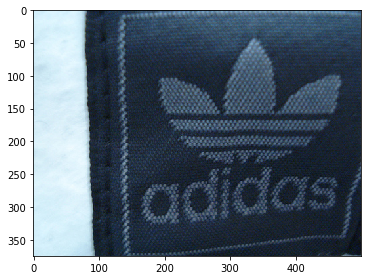

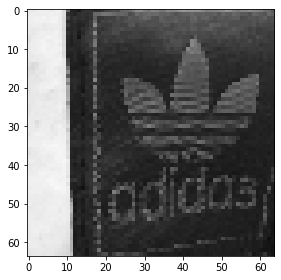

Initial Dimensions :  (493, 500, 3)
After Dimensions :  (4096,)
Brand: Adidas


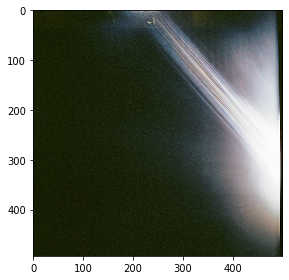

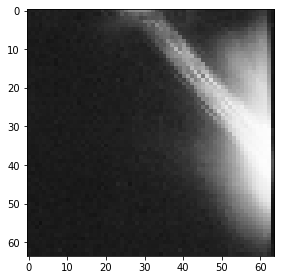

Initial Dimensions :  (266, 425, 3)
After Dimensions :  (4096,)
Brand: Adidas


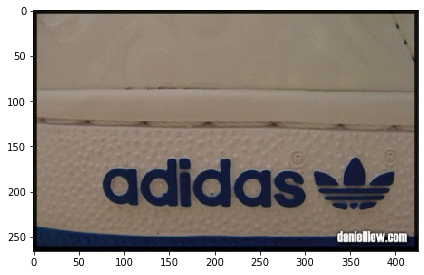

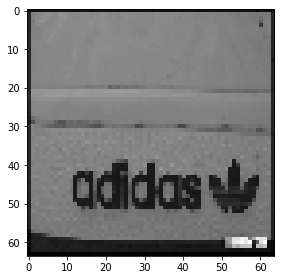

Initial Dimensions :  (375, 500, 3)
After Dimensions :  (4096,)
Brand: Adidas


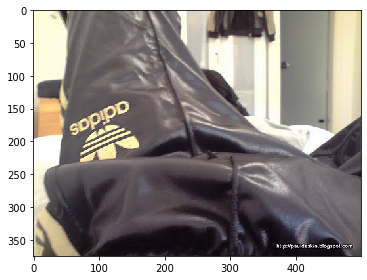

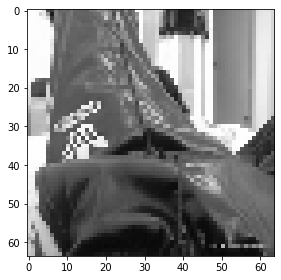

Initial Dimensions :  (240, 320, 3)
After Dimensions :  (4096,)
Brand: Adidas


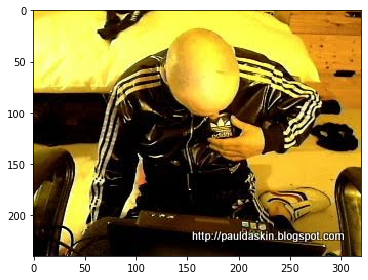

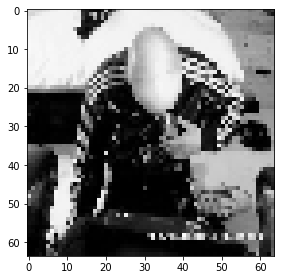

In [ ]:
width = 64
height = 64
dim = (width, height)
listImg=[]
listImgArr=[]
listClass=[]

data_logos=img_class.to_numpy()
img_logo_a=data_logos[0]
lab_logo_a=data_logos[1]
n_sample=len(img_class)

print('WHATS HAPPENING WITH THE IMAGES')
for i in range(len(img_class)) : 
    
    #Classification / Label
    classif=img_class.loc[i, "Brand"]
    
    #Path
    path=img_class.loc[i, "NameFile"]
    #print(path)
    #Got image from path
    image = io.imread(path)

    #Convert to Gray and Array
    arr_gray=color.rgb2gray(image) 


    #Reshape 64x64
    arr_gray_re=cv2.resize(arr_gray, dim)
    #print('After Dimensions : ',np.shape(arr_gray_re.flatten()))
    
    #Append Lists
    listImg.append([arr_gray_re,classif])
    listClass.append(classif)
    listImgArr.append([arr_gray_re.flatten(),classif])
        
    
    if i < 5:
        print('Initial Dimensions : ',image.shape)
        print('After Dimensions : ',np.shape(arr_gray_re.flatten()))
        print("Brand: "+ str(classif))
        io.imshow(image)
        plt.show()
        io.imshow(arr_gray_re)     
        plt.show()
        
        
#print(listImg)
#print(listClass)


In [ ]:
k2=270
df_LogoI=pd.DataFrame(listImgArr, columns=['image','classif'])
df_infoLogo=df_LogoI.groupby('classif').count()
df_infoLogo.reset_index(inplace=True)
df_infoLogo.rename(columns={'image':'count'}, inplace=True)
df_infoLogo['percentage']= round((df_infoLogo['count']*100)/k2,2)

In [ ]:
print(df_infoLogo)
print('Sum of the porcentage: '+str(df_infoLogo.percentage.sum()))

      classif  count  percentage
0      Adidas      5        1.85
1       Apple      5        1.85
2         BMW      5        1.85
3     Citroen      5        1.85
4    Cocacola      5        1.85
5         DHL      5        1.85
6       Fedex      5        1.85
7     Ferrari      5        1.85
8        Ford      5        1.85
9      Google      5        1.85
10         HP      5        1.85
11   Heineken      5        1.85
12      Intel      5        1.85
13  McDonalds      5        1.85
14       Mini      5        1.85
15        Nbc      5        1.85
16       Nike      5        1.85
17      Pepsi      5        1.85
18    Porsche      5        1.85
19       Puma      5        1.85
20    RedBull      5        1.85
21     Sprite      5        1.85
22  Starbucks      5        1.85
23     Texaco      5        1.85
24     Unicef      5        1.85
25   Vodafone      5        1.85
26      Yahoo      5        1.85
27       none    135       50.00
Sum of the porcentage: 99.95000000000002


In [ ]:
listImg=pd.DataFrame(listImg, columns=['image','classif'])

In [ ]:
xl=list(df_LogoI['image'])
yl=list(df_LogoI['classif'])

print("Information Array\n")
xl_train, xl_test, yl_train, yl_test = train_test_split(xl, yl, test_size=0.2, random_state=42)
print('Train size: '+str(len(yl_train)))
print('Test size: '+str(len(yl_test)))

xIl=list(listImg['image'])
yIl=list(listImg['classif'])

print("\nInformation Image\n")
x_trainIl, x_testIl, y_trainIl, y_testIl = train_test_split(xIl, yIl, test_size=0.2, random_state=42)
print('Train size: '+str(len(y_trainIl)))
print('Test size: '+str(len(y_testIl)))

Information Array

Train size: 216
Test size: 54

Information Image

Train size: 216
Test size: 54


In [ ]:
#What do we have
print(xl_train[:1])
print(yl_train[:1])

[array([0.30825604, 0.25301336, 0.28681757, ..., 0.35880561, 0.37399137,
       0.36217803])]
['Unicef']


In [ ]:
#Fitting the model
yl_train=np.array(yl_train)#.to_numpy()#converting to array
xl_train=np.array(xl_train)#.to_numpy()#Converting to array
print(np.shape(yl_train))
print(np.shape(xl_train))
model_svmLogo = svm.SVC(kernel='linear', C=1.0, random_state=0)
model_svmLogo.fit(xl_train, yl_train)

(216,)
(216, 4096)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
#Predict the values with test data
expectedl = yl_test
predictedl= model_svmLogo.predict(xl_test)

In [ ]:
#How did we do?
aScoreSVMLogo=accuracy_score(yl_test, predictedl)
print('Accuracy of Model SVM1:',aScoreSVMLogo)

Accuracy of Model SVM1: 0.42592592592592593


In [ ]:
#Their must be at least on incorrect prediction
(yl_test!=predictedl).any()

True

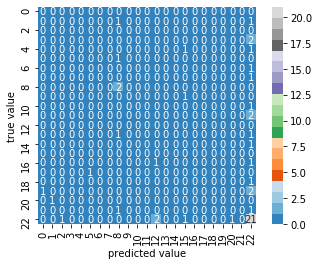

In [ ]:
#Confusion Matrix. 

matl = confusion_matrix(yl_test, predictedl)

sns.heatmap(matl, square=True, annot=True, cbar=True, cmap="tab20c")
plt.xlabel('predicted value')
plt.ylabel('true value');

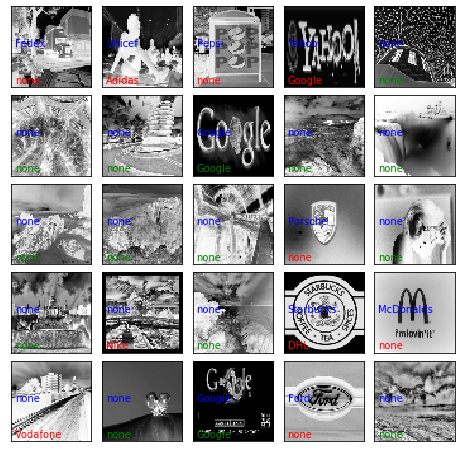

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

#test_images = x_testI.reshape(-1, 8, 8)

for i, ax in enumerate(axes.flat):
    ax.imshow(x_testIl[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.5, yl_test[i], transform=ax.transAxes,color='blue')
    ax.text(0.05, 0.05,predictedl[i],
            transform=ax.transAxes,
            color='green' if (yl_test[i] == predictedl[i]) else 'red')